# TP Final Gastón Vernhes (23-09-20)

IMPORTANTE: 
Este código está ordenado en el sentido de que primero está el código escrito y a continuación está el resultado (en el código de la presentación primero está el resultado y al final el código, el contenido es el mismo, pero creo que está mejor ordenado así. Si alguien quiere el otro, avise y lo paso)

ACLARACION: 


1) para que se baje el ADX, van a tener que instalar pandas_ta (!pip install pandas_ta)

2) paso el indicador que lo retoqué en un archivo .py que armé. Lo van a necesitar para correr el ADX

# 1) Backtest Básico

In [200]:
import yfinance as yf
import pandas as pd
import numpy as np
import analisis_tecnico_GV as at


In [2]:
def getData(symbol, start='2000-01-01', interval='1d', end=None):
    data = yf.download(symbol, start=start, end=end, interval=interval, auto_adjust=True)
    return data.dropna()

In [275]:
def addSignal_DMI(data, adx_q = 14, adx_accion = 25):
    length = adx_q
    data['Variacion'] = data.Close.pct_change()*100
    data['Volatilidad_diaria'] = data.Variacion.rolling(250).std()
    data['Volatilidad_anual'] = data.Variacion.rolling(250).std() * 250**0.5
    data['CumProd'] = (((data.Variacion/100)+1).cumprod())
    

    data = at.adx(data, length = adx_q) #calculo el ADX

    data['Señal'] = 'Sin Señal'
    comprar = (data['posDI_'+str(length)] > data['negDI_'+str(length)]) & (data['ADX_'+str(length)] > adx_accion)
    data.loc[comprar, 'Señal'] = 'Compra'

    vender = (data['posDI_'+str(length)] < data['negDI_'+str(length)]) & (data['ADX_'+str(length)] > adx_accion)
    data.loc[vender, 'Señal'] = 'Venta'

    return data

In [278]:
def getActions_DMI(data, long_short='both', adx_q = 14):
    data = data
    # Una sola entrada y salida por vez
    actions = data.loc[data.Señal != 'Sin Señal', ['Close','negDI_'+str(adx_q),'posDI_'+str(adx_q),'ADX_'+str(adx_q),'Señal']].copy()
    actions['Señal'] = np.where(actions.Señal != actions.Señal.shift(), actions.Señal,'Sin Señal')
    actions = actions.loc[actions.Señal != 'Sin Señal'].copy()    
    
    try:
        if long_short=='long':
            if actions.iloc[0,3]=='Venta':
                actions = actions.iloc[1:]
            if actions.iloc[-1,3]=='Compra':
                actions = actions.iloc[:-1]
        if long_short=='short':
            if actions.iloc[0,3]=='Compra':
                actions = actions.iloc[1:]
            if actions.iloc[-1,3]=='Venta':
                actions = actions.iloc[:-1]
    except:
        pass
            
    return actions

In [5]:
def getActions_DMI_comp(data, long_short='both', adx_q = 14):
    '''
    Esta funcion sirve para luego calcular la variacion diaria de la estrategia y poder compararlo con un buy&hold o un benchmark
    '''
    data = data
    # Una sola entrada y salida por vez
    actions = data.loc[data.Señal != 'Sin Señal', ['Close','negDI_'+str(adx_q),'posDI_'+str(adx_q),'ADX_'+str(adx_q),'Señal']].copy()
    actions['Señal'] = np.where(actions.Señal != actions.Señal.shift(), actions.Señal,'Sin Señal')
    #actions = actions.loc[actions.Señal != 'Sin Señal'].copy()    
    
    try:
        if long_short=='long':
            if actions.iloc[0,3]=='Venta':
                actions = actions.iloc[1:]
            if actions.iloc[-1,3]=='Compra':
                actions = actions.iloc[:-1]
        if long_short=='short':
            if actions.iloc[0,3]=='Compra':
                actions = actions.iloc[1:]
            if actions.iloc[-1,3]=='Venta':
                actions = actions.iloc[:-1]
    except:
        pass
            
    return actions

In [6]:
def getTrades(actions, long_short='both'):
    try:
        trades = []
        cerrado = True
        t = {}
        for index, row in actions.iterrows():          
            if cerrado == True:
                t['fecha_in'] = index
                t['price_in'] = row['Close']
                if row['Señal']=='Venta':
                    t['side'] = 'short'
                else:
                    t['side'] = 'long'   
                cerrado = False            #acá indica que se abrio el trade
            else:
                t['price_out'] = row['Close']
                t['fecha_out'] = index
                trades.append(t)           
                cerrado = True             #acá indica que se cerró el trade
                t = {}                     #acá resetea el diccionario para el proximo trade
                t['fecha_in'] = index      #acá ya empieza de nuevo con el siguiente trade, tomando la logica de que cuando sale del short, entra en un long con los mismos precios (y viceversa)
                t['price_in'] = row['Close']
                if row['Señal']=='Venta':
                    t['side'] = 'short'
                else:
                    t['side'] = 'long'   
                cerrado = False
    except:
        trades = []

    try:    
        res = pd.DataFrame(trades)
        res['yield'] = np.where(res.side=='long', res.price_out/res.price_in-1, res.price_in/res.price_out-1 )

        res['dias'] = (res.fecha_out - res.fecha_in).dt.days

        if long_short=='long':
            res = res.loc[res.side=='long']

        if long_short=='short':
            res = res.loc[res.side=='short']
    except:
        res = pd.DataFrame(trades)        
            
    return res

In [358]:
def getTradesMetrics(trades):
    try:
        trades['factor'] =  trades['yield']+1
        longs = trades.loc[trades.side=='long']
        shorts = trades.loc[trades.side=='short']
        res = pd.DataFrame(index=['Shorts','Longs','Total'])  #arma un DF vacio con 3 filas (Shorts, Longs y Total)

        # prod() multiplica todas las celdas de esa columna, y luego recien se le resta el 1 (la resta se hace despues de todas las multplicaciones)
        res.loc['Longs', 'Yield %'] = (longs.factor.prod()-1)*100  #crea la columna Yields, y le pone el dato para los Longs
        res.loc['Shorts', 'Yield %']  = (shorts.factor.prod()-1)*100 #agrega el dato para la columna Shorts
        res.loc['Total', 'Yield %']  = (trades.factor.prod()-1)*100  #agrega el dato para la columna Total 

        res.loc['Longs', 'Dias']  = longs.dias.sum()
        res.loc['Shorts', 'Dias'] = shorts.dias.sum()
        res.loc['Total', 'Dias'] = trades.dias.sum()


        res['TIR %'] = np.nan
        if res.loc['Longs', 'Dias'] > 0:
            res.loc['Longs', 'TIR %'] = ((res.loc['Longs','Yield %']/100+1)**(1/(res.loc['Longs', 'Dias'] /365))-1)*100

        if res.loc['Shorts', 'Dias'] > 0:
            res.loc['Shorts', 'TIR %'] = ((res.loc['Shorts','Yield %']/100+1)**(1/(res.loc['Shorts', 'Dias'] /365))-1)*100

        if res.loc['Total', 'Dias'] > 0:    
            res.loc['Total', 'TIR %'] = ((res.loc['Total','Yield %']/100+1)**(1/(res.loc['Total', 'Dias'] /365))-1)*100

        #res['TNA %'] = (((1+res['TIR %']/100)**(1/12)-1)*12)*100
        
        res.loc['Longs', 'cant_ops']  = len(longs)
        res.loc['Shorts', 'cant_ops'] = len(shorts)
        res.loc['Total', 'cant_ops'] = len(trades)

    
    except:
        res = pd.DataFrame(index=['Shorts','Longs','Total'], columns = ['Yield %', 'Dias','TIR %','TNA %','cant_ops'])

    return res.round(2)

## Junto las funciones para la Estrategia

### Estrategia con DMI y ADX

In [366]:
%%time

length = 14 #numero de ruedas para la media del DMI
symbol = 'KO'
adx_valor_entrada = 25

data = getData(symbol)
df = addSignal_DMI(data, adx_q = length, adx_accion = adx_valor_entrada)
actions = getActions_DMI(df, long_short='both', adx_q = length)
trades = getTrades(actions, long_short='both')
tradesMetrics = getTradesMetrics(trades)

[*********************100%***********************]  1 of 1 completed


C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Wall time: 1.07 s


In [360]:
data

,Open,High,Low,Close,Volume,Variacion,Volatilidad_diaria,Volatilidad_anual,CumProd
Date,,,,,,,,,
2000-01-03,12.152072,12.152072,11.575896,11.811604,10997000.0,NaN,NaN,NaN,NaN
2000-01-04,11.811606,11.903271,11.654468,11.824701,7308000.0,0.110881,NaN,NaN,1.001109
2000-01-05,11.824702,12.034221,11.746133,11.929461,9457400.0,0.885943,NaN,NaN,1.009978
2000-01-06,11.929462,12.086601,11.850893,11.942557,7129200.0,0.109777,NaN,NaN,1.011087
2000-01-07,12.125885,12.728251,12.125885,12.728251,11474000.0,6.578936,NaN,NaN,1.077606
...,...,...,...,...,...,...,...,...,...
2020-09-17,50.220001,50.630001,49.939999,50.549999,13287100.0,-0.472537,2.109594,33.355604,4.279689
2020-09-18,50.750000,51.160000,50.209999,50.450001,23816600.0,-0.197821,2.109468,33.353617,4.271223
2020-09-21,49.750000,50.020000,48.610001,49.090000,17514800.0,-2.695740,2.116300,33.461637,4.156082


In [361]:
#agrego las señales
df

,Open,High,Low,Close,Volume,Variacion,Volatilidad_diaria,Volatilidad_anual,CumProd,posDI_14,negDI_14,ADX_14,Señal
Date,,,,,,,,,,,,,
2000-01-03,12.152072,12.152072,11.575896,11.811604,10997000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin Señal
2000-01-04,11.811606,11.903271,11.654468,11.824701,7308000.0,0.110881,NaN,NaN,1.001109,NaN,NaN,NaN,Sin Señal
2000-01-05,11.824702,12.034221,11.746133,11.929461,9457400.0,0.885943,NaN,NaN,1.009978,NaN,NaN,NaN,Sin Señal
2000-01-06,11.929462,12.086601,11.850893,11.942557,7129200.0,0.109777,NaN,NaN,1.011087,NaN,NaN,NaN,Sin Señal
2000-01-07,12.125885,12.728251,12.125885,12.728251,11474000.0,6.578936,NaN,NaN,1.077606,NaN,NaN,NaN,Sin Señal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-17,50.220001,50.630001,49.939999,50.549999,13287100.0,-0.472537,2.109594,33.355604,4.279689,26.715508,17.156876,28.571905,Compra
2020-09-18,50.750000,51.160000,50.209999,50.450001,23816600.0,-0.197821,2.109468,33.353617,4.271223,28.762528,15.948899,28.578091,Compra
2020-09-21,49.750000,50.020000,48.610001,49.090000,17514800.0,-2.695740,2.116300,33.461637,4.156082,25.079406,25.041613,26.542184,Compra


In [362]:
#filtra las señales
actions

,Close,negDI_14,posDI_14,ADX_14,Señal
Date,,,,,
2000-01-21,14.011552,0.000000,47.317231,100.000000,Compra
2000-01-27,12.466348,28.090146,22.303189,44.980495,Venta
2000-03-30,10.251344,20.632463,24.666294,25.114097,Compra
2000-07-12,11.924803,27.532508,26.609100,26.100421,Venta
2000-07-13,12.309901,25.177547,31.282747,25.008341,Compra
...,...,...,...,...,...
2019-05-10,45.915874,24.334220,26.348505,28.301445,Compra
2020-02-25,56.345188,25.094809,19.123798,37.600818,Venta
2020-04-09,48.168934,25.012491,28.417780,31.631624,Compra


In [363]:
#calcula los resultados
trades

,fecha_in,price_in,side,price_out,fecha_out,yield,dias,factor
0,2000-01-21,14.011552,long,12.466348,2000-01-27,-0.110281,6,0.889719
1,2000-01-27,12.466348,short,10.251344,2000-03-30,0.216070,63,1.216070
2,2000-03-30,10.251344,long,11.924803,2000-07-12,0.163243,104,1.163243
3,2000-07-12,11.924803,short,12.309901,2000-07-13,-0.031284,1,0.968716
4,2000-07-13,12.309901,long,11.184480,2000-08-31,-0.091424,49,0.908576
...,...,...,...,...,...,...,...,...
87,2019-05-09,45.163158,short,45.915874,2019-05-10,-0.016393,1,0.983607
88,2019-05-10,45.915874,long,56.345188,2020-02-25,0.227140,291,1.227140
89,2020-02-25,56.345188,short,48.168934,2020-04-09,0.169741,44,1.169741
90,2020-04-09,48.168934,long,46.134041,2020-04-13,-0.042245,4,0.957755


In [364]:
tradesMetrics

,Yield %,Dias,TIR %,cant_ops
Shorts,-47.30,3785.0,-5.99,46.0
Longs,90.52,3754.0,6.47,46.0
Total,0.41,7539.0,0.02,92.0


### Análisis Agregado

In [365]:
#recalculo actions y le pido que me traiga los datos de todos los dias para luego poder calcular el valor diario de la cartera

actions2 = getActions_DMI_comp(df, long_short='both', adx_q = length)
actions2

,Close,negDI_14,posDI_14,ADX_14,Señal
Date,,,,,
2000-01-21,14.011552,0.000000,47.317231,100.000000,Compra
2000-01-24,13.592517,12.536797,38.492607,74.522292,Sin Señal
2000-01-25,13.802035,14.052387,32.235494,61.895291,Sin Señal
2000-01-26,13.212763,12.582292,27.501388,55.024734,Sin Señal
2000-01-27,12.466348,28.090146,22.303189,44.980495,Venta
...,...,...,...,...,...
2020-09-15,51.049999,11.873567,30.076072,28.193784,Sin Señal
2020-09-16,50.790001,11.988716,28.509537,29.093793,Sin Señal
2020-09-17,50.549999,17.156876,26.715508,28.571905,Sin Señal


In [11]:
#Calcula el valor diario de la cartera

#ACLARACION: en long_short las opciones both y short empezaron a tirar error

def estrategia_valor_diario(data, long_short='both'):

    import numpy as np

    actions2 = data
    actions2.dropna()

    actions2['valor_cartera'] = 100
    actions2['cantVNlong'] = 0
    actions2['saldoVNlong'] = 0
    actions2['resultLong'] = 0

    #try: 
    # ----------------------------------------------------------------------------
    # ----------------------------------------------------------------------------
    #VERSION BOTH (long y short)

    if long_short == 'both':
        #LONG----------------------------
        for i in range(len(actions2)):

            if actions2.Señal.iloc[i] == 'Compra':
                actions2['cantVNlong'].iloc[i] = actions2.valor_cartera[i] / actions2.Close[i]
                actions2['saldoVNlong'].iloc[i] =  actions2.cantVNlong[i]
                actions2['resultLong'].iloc[i] = 0

            if (actions2.Señal.iloc[i] == 'Sin Señal'):
                actions2['cantVNlong'].iloc[i] = 0
                actions2['saldoVNlong'].iloc[i] =  np.where(pd.isna(actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i]) == True,
                                                           0, actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i])
                actions2['resultLong'].iloc[i] = np.where(pd.isna((actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )) == True,
                                                         0, (actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

            if (actions2.Señal.iloc[i] == 'Venta'):
                actions2['cantVNlong'].iloc[i] = np.where(pd.isna(-actions2.saldoVNlong.shift()[i]) == True, 0,
                                                         -actions2.saldoVNlong.shift()[i])
                actions2['saldoVNlong'].iloc[i] =  np.where(pd.isna(actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i]) == True,
                                                           0, actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i])
                actions2['resultLong'].iloc[i] = np.where(pd.isna((actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )) == True,
                                                         0, (actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

        #SHORT----------------------------

        for i in range(len(actions2)):

            if actions2.Señal.iloc[i] == 'Venta':
                actions2['cantVNshort'].iloc[i] = - actions2.valor_cartera[i] / actions2.Close[i]
                actions2['saldoVNshort'].iloc[i] =  actions2.cantVNshort[i]
                actions2['resultShort'].iloc[i] = 0

            if (actions2.Señal.iloc[i] == 'Sin Señal'):
                actions2['cantVNshort'].iloc[i] = 0
                actions2['saldoVNshort'].iloc[i] =  np.where(pd.isna(actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i]) == True,
                                                             0, actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i])
                actions2['resultShort'].iloc[i] = np.where(pd.isna((actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )),
                                                           0, (actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))


            if (actions2.Señal.iloc[i] == 'Compra'):
                actions2['cantVNshort'].iloc[i] = np.where(pd.isna(-actions2.saldoVNshort.shift()[i]) == True, 0,
                                                           -actions2.saldoVNshort.shift()[i])
                actions2['saldoVNshort'].iloc[i] =  np.where(pd.isna(actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i]) == True,
                                                             0, actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i])
                actions2['resultShort'].iloc[i] = np.where(pd.isna(actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ),
                                                           0, (actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

        #Sumo el valor de la cartera---------------

            if i == 0:
                pass
            else:
                actions2['valor_cartera'].iloc[i] = actions2.valor_cartera.shift()[i] + actions2.resultLong[i] + actions2.resultShort[i]

    # ----------------------------------------------------------------------------
    # ----------------------------------------------------------------------------
    #VERSION LONG

    if long_short == 'long':
        for i in range(len(actions2)):

            if actions2.Señal.iloc[i] == 'Compra':
                actions2['cantVNlong'].iloc[i] = actions2.valor_cartera[i] / actions2.Close[i]
                actions2['saldoVNlong'].iloc[i] =  actions2.cantVNlong[i]
                actions2['resultLong'].iloc[i] = 0

            if (actions2.Señal.iloc[i] == 'Sin Señal'):
                actions2['cantVNlong'].iloc[i] = 0
                actions2['saldoVNlong'].iloc[i] =  np.where(pd.isna(actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i]) == True,
                                                           0, actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i])
                actions2['resultLong'].iloc[i] = np.where(pd.isna((actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )) == True,
                                                         0, (actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

            if (actions2.Señal.iloc[i] == 'Venta'):
                actions2['cantVNlong'].iloc[i] = np.where(pd.isna(-actions2.saldoVNlong.shift()[i]) == True, 0,
                                                         -actions2.saldoVNlong.shift()[i])
                actions2['saldoVNlong'].iloc[i] =  np.where(pd.isna(actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i]) == True,
                                                           0, actions2.cantVNlong[i] + actions2.saldoVNlong.shift()[i])
                actions2['resultLong'].iloc[i] = np.where(pd.isna((actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )) == True,
                                                         0, (actions2.saldoVNlong[i] - actions2.cantVNlong[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

            if i == 0:
                pass
            else:
                actions2['valor_cartera'].iloc[i] = actions2.valor_cartera.shift()[i] + actions2.resultLong[i]

    # ----------------------------------------------------------------------------
    # ----------------------------------------------------------------------------
    #VERSION SHORT

    if long_short == 'short':
        for i in range(len(actions2)):

            if actions2.Señal.iloc[i] == 'Venta':
                actions2['cantVNshort'].iloc[i] = - actions2.valor_cartera[i] / actions2.Close[i]
                actions2['saldoVNshort'].iloc[i] =  actions2.cantVNshort[i]
                actions2['resultShort'].iloc[i] = 0

            if (actions2.Señal.iloc[i] == 'Sin Señal'):
                actions2['cantVNshort'].iloc[i] = 0
                actions2['saldoVNshort'].iloc[i] =  np.where(pd.isna(actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i]) == True,
                                                             0, actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i])
                actions2['resultShort'].iloc[i] = np.where(pd.isna((actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] )),
                                                           0, (actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))


            if (actions2.Señal.iloc[i] == 'Compra'):
                actions2['cantVNshort'].iloc[i] = np.where(pd.isna(-actions2.saldoVNshort.shift()[i]) == True, 0,
                                                           -actions2.saldoVNshort.shift()[i])
                actions2['saldoVNshort'].iloc[i] =  np.where(pd.isna(actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i]) == True,
                                                             0, actions2.cantVNshort[i] + actions2.saldoVNshort.shift()[i])
                actions2['resultShort'].iloc[i] = np.where(pd.isna(actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ),
                                                           0, (actions2.saldoVNshort[i] - actions2.cantVNshort[i]) * (actions2.Close[i] - actions2.Close.shift()[i] ))

            if i == 0:
                pass
            else:
                actions2['valor_cartera'].iloc[i] = actions2.valor_cartera.shift()[i] + actions2.resultShort[i]

    actions2['Variacion'] = actions2.valor_cartera.pct_change()*100
    actions2['CumProd'] = (((actions2.Variacion/100)+1).cumprod())
    actions2['Volatilidad_diaria'] = actions2.Variacion.rolling(250).std()
    actions2['Volatilidad_anual'] = actions2.Variacion.rolling(250).std() * 250**0.5

#except: 
    #actions2 = print('Error: lo más probable es que el DF inicial no tenga la opcion seleccionada para el "long_short"')
# devuelve el valor de la funcion
    
    return actions2


In [12]:
estrategia_diario = estrategia_valor_diario(actions2, long_short='long')
pd.options.display.max_rows = 20
estrategia_diario

C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Close,negDI_14,posDI_14,ADX_14,Señal,valor_cartera,cantVNlong,saldoVNlong,resultLong,Variacion,CumProd,Volatilidad_diaria,Volatilidad_anual
Date,,,,,,,,,,,,,
2000-01-21,14.011552,0.000000,47.317231,100.000000,Compra,100.000000,7.136968,7.136968,0.000000,NaN,NaN,NaN,NaN
2000-01-24,13.592517,12.536797,38.492607,74.522292,Sin Señal,97.009361,0.000000,7.136968,-2.990639,-2.990639,0.970094,NaN,NaN
2000-01-25,13.802035,14.052387,32.235494,61.895291,Sin Señal,98.504687,0.000000,7.136968,1.495326,1.541425,0.985047,NaN,NaN
2000-01-26,13.212763,12.582292,27.501388,55.024734,Sin Señal,94.299068,0.000000,7.136968,-4.205619,-4.269461,0.942991,NaN,NaN
2000-01-27,12.466348,28.090146,22.303189,44.980495,Venta,88.971927,-7.136968,0.000000,-5.327141,-5.649198,0.889719,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-15,51.049999,11.873567,30.076072,28.193784,Sin Señal,180.941128,0.000000,1.974334,0.671274,0.372372,1.809411,0.877226,13.870168
2020-09-16,50.790001,11.988716,28.509537,29.093793,Sin Señal,180.427804,0.000000,1.974334,-0.513323,-0.283696,1.804278,0.877427,13.873342
2020-09-17,50.549999,17.156876,26.715508,28.571905,Sin Señal,179.953961,0.000000,1.974334,-0.473843,-0.262622,1.799540,0.877622,13.876417


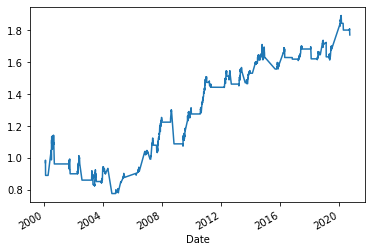

In [13]:
estrategia_diario.CumProd.plot()

In [ ]:
#grafico rapido de comprobacion del Valor de la Cartera
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(12,5), ncols=1, nrows=1)
fig.suptitle('Evolucion Estrategia', size = 12, y = 0.95)

axs.plot(estrategia_diario.index, estrategia_diario.CumProd, color='green', ls='-', label='Estrategia Media')


## Métricas Anuales

In [14]:
def metrica_anual(df, estrategia = False):
    '''
    df: es el DF que hay que pasarle, debe contener las variaciones diarias de la estrategia, buy&hold o indice
    
    estrategia:
        - False: si el df es de buy&hold o de algun indice, y trae la columna Close
        - True: si el df es de una estrategia nuestra
    '''
    if estrategia == True:
        #Calculamos la variacion del buy and hold
        data = pd.DataFrame(df.groupby(df.index.year).valor_cartera.last().pct_change()*100)
        data.iloc[0] = (df.groupby(df.index.year).valor_cartera.last().iloc[0]/df.groupby(df.index.year).valor_cartera.first().iloc[0] - 1)*100
        data.columns = ['Variacion']
        data['Desvio'] = (df.groupby(df.index.year).Variacion.std() * 250**0.5) 

        #calculo el desvio negativo
        df_neg = df.loc[df.Variacion < 0]
        data['DesvioNeg'] = (df_neg.groupby(df_neg.index.year).Variacion.std() * 250**0.5)

        #Ratios de Performance
        data['RetAjustStd'] = data['Variacion']/data['Desvio']
        data['RetAjustStdDown'] = data['Variacion']/data['DesvioNeg']
    
    if estrategia == False:
        #Calculamos la variacion del buy and hold
        data = pd.DataFrame(df.groupby(df.index.year).Close.last().pct_change()*100)
        data.iloc[0] = (df.groupby(df.index.year).Close.last().iloc[0]/df.groupby(df.index.year).Close.first().iloc[0] - 1)*100
        data.columns = ['Variacion']
        data['Desvio'] = (df.groupby(df.index.year).Variacion.std() * 250**0.5)

        #calculo el desvio negativo
        df_neg = df.loc[df.Variacion < 0]
        data['DesvioNeg'] = (df_neg.groupby(df_neg.index.year).Variacion.std() * 250**0.5)

        #Ratios de Performance
        data['RetAjustStd'] = data['Variacion']/data['Desvio']
        data['RetAjustStdDown'] = data['Variacion']/data['DesvioNeg']

    return data.round(2)

#### Métricas Anuales de la Estrategia

In [15]:
estrategia_anual = metrica_anual(estrategia_diario, estrategia = True)
estrategia_anual

,Variacion,Desvio,DesvioNeg,RetAjustStd,RetAjustStdDown
Date,,,,,
2000,-3.85,41.77,40.09,-0.09,-0.10
2001,-6.42,16.44,15.75,-0.39,-0.41
2002,-4.42,26.63,36.99,-0.17,-0.12
2003,9.71,18.53,21.45,0.52,0.45
2004,-15.08,25.64,52.21,-0.59,-0.29
...,...,...,...,...,...
2016,1.92,11.15,13.50,0.17,0.14
2017,3.92,4.75,3.26,0.83,1.20
2018,2.07,10.21,7.37,0.20,0.28


#### Métricas Anuales del Buy&Hold

In [16]:
buy_hold_anual = metrica_anual(df, estrategia = False)
buy_hold_anual

,Variacion,Desvio,DesvioNeg,RetAjustStd,RetAjustStdDown
Date,,,,,
2000,10.94,42.45,24.29,0.26,0.45
2001,-19.99,24.77,16.36,-0.81,-1.22
2002,-3.94,27.69,21.13,-0.14,-0.19
2003,20.55,20.52,13.59,1.00,1.51
2004,-14.25,17.02,14.76,-0.84,-0.97
...,...,...,...,...,...
2016,-0.36,14.14,12.01,-0.03,-0.03
2017,14.38,9.01,6.62,1.60,2.17
2018,6.77,14.93,10.99,0.45,0.62


#### Métricas Anuales del Benchmark

In [17]:
benchmark = 'SPY'
bmark_data = getData(benchmark)
bmark_signal = addSignal_DMI(bmark_data, adx_q = length)
bmark_anual = metrica_anual(bmark_signal)
bmark_anual



[*********************100%***********************]  1 of 1 completed


,Variacion,Desvio,DesvioNeg,RetAjustStd,RetAjustStdDown
Date,,,,,
2000,-8.85,23.84,13.97,-0.37,-0.63
2001,-11.76,22.00,14.86,-0.53,-0.79
2002,-21.58,26.34,14.86,-0.82,-1.45
2003,28.18,16.46,10.18,1.71,2.77
2004,10.70,11.10,7.44,0.96,1.44
...,...,...,...,...,...
2016,12.00,13.01,10.00,0.92,1.20
2017,21.71,6.72,4.98,3.23,4.36
2018,-4.57,16.97,13.90,-0.27,-0.33


## Graficamos

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [179]:
def grafico_indicador2(df_actions, df_signal, length, año = '2010', indicador = 'nombre' ):
    '''
    df_actions: provee las acciones de "compra" y "venta" netas de las repeticiones
    df_signal: provee el indice de dias para armar el grafico. El indice de df_actions está filtrado por las repeticiones y tiene menos dias
    '''
    df = df_actions.loc[df_actions.index > año]
    df2 = df_signal.loc[df_signal.index > año]

    compra = (df.Close * 0.95).loc[df.Señal=='Compra']
    venta = (df.Close * 1.05).loc[df.Señal=='Venta']

    # Graficamos
    fig, axs = plt.subplots(figsize=(15,7), ncols=1, nrows=2, gridspec_kw = {'height_ratios': [2,1]})
    fig.suptitle('Precio de '+symbol+' con '+indicador, size = 17, y = 0.92)
    #f1 = axs.plot(df2.Close, c="k", ls="-", lw=1.5, label = 'Precio')
    
    axs[0].plot(df2.Close, c="k", ls="-", lw=1.5, label = 'Precio') #es para el indice
    axs[0].plot(compra.index, compra, "^", markersize=10, c='g') #señal de compra
    axs[0].plot(venta.index, venta, "v", markersize=10, c='r', alpha=0.5) #señal de venta
    axs[0].legend(loc='upper left', fontsize=10)
    #plt[0].ylabel('Precio', size = 13, )

    
    
    axs[1].plot(df2.index, df2['posDI_'+str(length)], lw = 1, color = 'brown', alpha = 0.5, label = '+DI', zorder = 5)
    axs[1].plot(df2.index, df2['negDI_'+str(length)], lw = 1, color = 'blue', alpha = 0.5, label = '-DI', zorder = 5)
    axs[1].plot(df2.index, df2['ADX_'+str(length)], lw = 2, color = 'black', label = 'ADX', zorder = 10)
    axs[1].legend(loc='upper left', fontsize=9)
    
    for idx, row in df.iterrows():
        if row.Señal=='Compra':
            axs[1].axvline(x=idx, c='green', lw=1, zorder = 2)
        if row.Señal=='Venta':
            axs[1].axvline(x=idx, ymin=0, c='red', ls="--", lw=1, zorder = 2)
    
    fig.subplots_adjust(hspace=0)
    return plt.show()

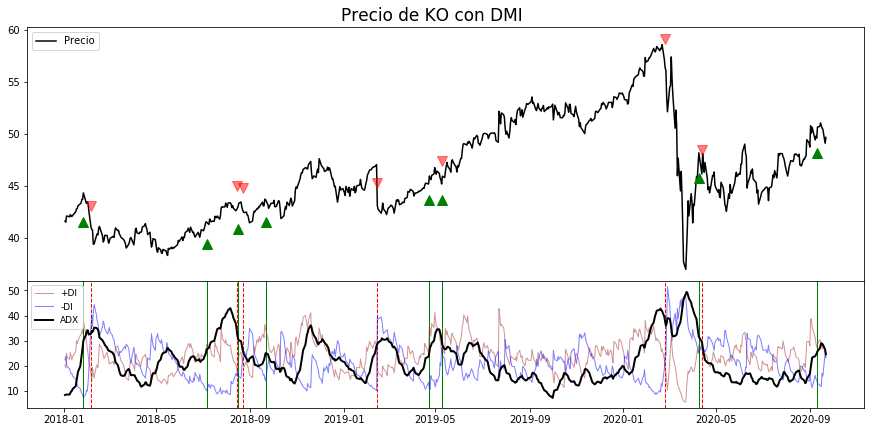

In [182]:
grafico_indicador2(actions2,df, length, año = '2018', indicador = 'DMI')

In [187]:
def grafico_retornos_anuales(df_estrategia, df_buyhold, df_bmark, tipo = 'Variacion'):

    if tipo == 'Variacion':
        title = 'Comparacion Estrategia, Buy&Hold, Benchmark (Retorno %)'

    if tipo == 'RetAjustStd':
        title ='Comparacion Estrategia, Buy&Hold, Benchmark (Retorno Ajustado por Desvio)'

    if tipo == 'RetAjustStdDown':
        title ='Comparacion Estrategia, Buy&Hold, Benchmark (Retorno Ajustado por Desvio Negativo)'

    fig, axs = plt.subplots(figsize=(15,5), ncols=1, nrows=1)
    fig.suptitle(title, size = 17, y = 0.95)

    axs.bar(estrategia_anual.index , estrategia_anual[f'{tipo}'], label = 'Estrategia',width = 0.2, color = 'green', alpha  = 0.7)
    axs.plot(estrategia_anual.index, [estrategia_anual[f'{tipo}'].mean()]*len(estrategia_anual), color='green', ls='--', label='Estrategia Media')
    
    axs.bar(buy_hold_anual.index + 0.20, buy_hold_anual[f'{tipo}'], label = 'Buy & Hold', width = 0.2, color = 'green',alpha  = 0.4)
    axs.plot(buy_hold_anual.index, [buy_hold_anual[f'{tipo}'].mean()]*len(buy_hold_anual), color='green', ls='--', label='Buy & Hold Media', alpha  = 0.4)
    
    axs.bar(bmark_anual.index + 0.4, bmark_anual[f'{tipo}'], label = 'Benchmark',width = 0.2, color = 'black', alpha = 1)
    axs.plot(bmark_anual.index, [bmark_anual[f'{tipo}'].mean()]*len(bmark_anual), color='black', ls='--', label='Bmark Media',alpha = 1)

    #Ejes
    plt.ylabel('Porcentaje', size = 15, )
    plt.xticks(estrategia_anual.index) #es para poner la cantidad de datos en el eje X
        #cambio de formato a porcentaje en el eje Y
    if tipo == 'Variacion':
        formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
        axs.yaxis.set_major_formatter(formatter)

    axs.legend()
    
    return plt.show()

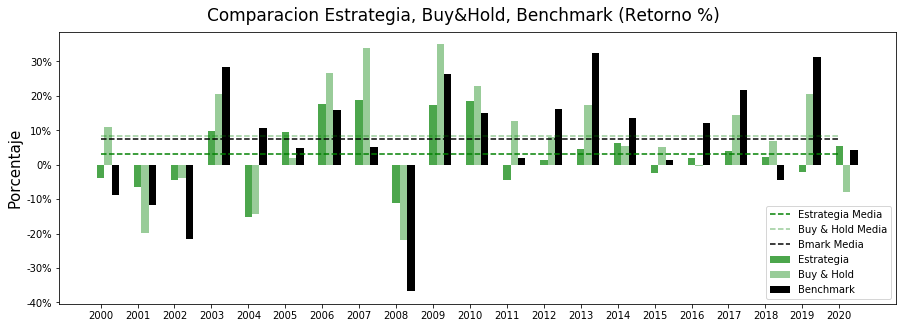

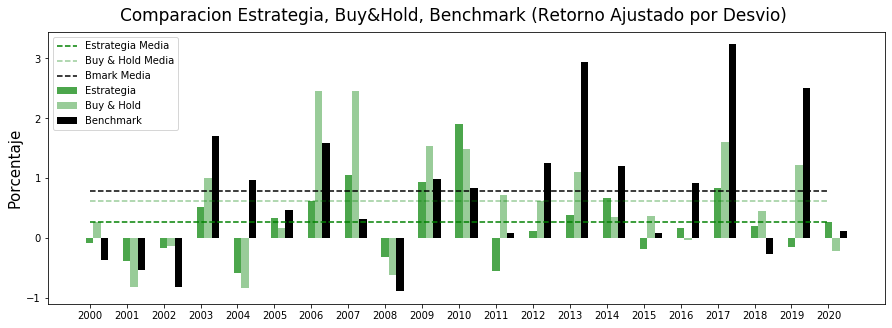

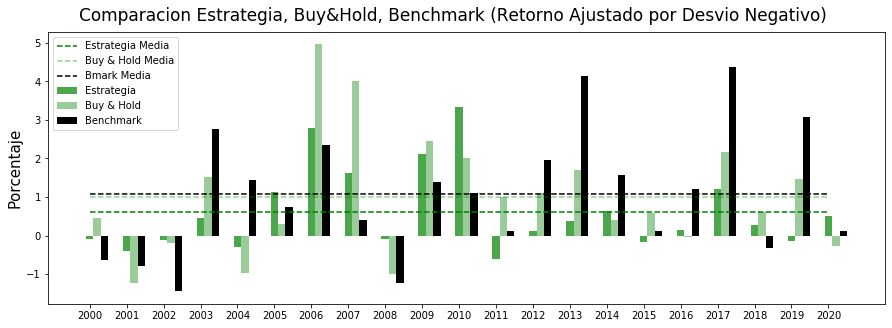

In [188]:
grafico_retornos_anuales(estrategia_diario, df, bmark_signal, tipo = 'Variacion')
grafico_retornos_anuales(estrategia_diario, df, bmark_signal, tipo = 'RetAjustStd')
grafico_retornos_anuales(estrategia_diario, df, bmark_signal, tipo = 'RetAjustStdDown')

In [22]:
def cagr(df, estrategia = False):
    
    if estrategia == True:
        valor_inicial = df.valor_cartera[0]
        valor_final  = df.valor_cartera[len(df)-1]
        fecha_inicial = df.index[0]
        fecha_final = df.index[len(df)-1]
        dias = (fecha_final-fecha_inicial).days

        cagr = round(((valor_final / valor_inicial) ** (365/dias) -1 ) * 100,2)
 
    if estrategia == False:
        valor_inicial = df.Close[0]
        valor_final  = df.Close[len(df)-1]
        fecha_inicial = df.index[0]
        fecha_final = df.index[len(df)-1]
        dias = (fecha_final-fecha_inicial).days

        cagr = round(((valor_final / valor_inicial) ** (365/dias) -1 ) * 100,2)
    
    return cagr

In [202]:
#Retornos diarios Acumulados 

def grafico_retornos_acumulados(df_estrategia, df_buyhold, df_bmark, tipo = 'retornos_desvio'):
   
    '''
    df_estrategia: pasar el dataframe de la estrategia (es el addSignal)
    df_buyhold: pasar el dataframe del buy and hold (es el addSignal)
    df_bmark: pasar el dataframe del benchmark (es el addSignal del benchmark)
    
    tipo: 
        valores: retornos, retornos_desvio
            retornos: es solo el cambio porcentual diario acumulado
            retornos_desvio: es solo el cambio porcentual diario acumulado ajustado por un rolling de volatilidad anual
    
    '''
    import datetime as dt
    
    if tipo == 'retornos':
        divisor_estrategia = 1
        divisor_buyhold = 1
        divisor_bmark = 1
        title = 'Retornos Acumulados'
        
    if tipo == 'retornos_desvio':
        divisor_estrategia = df_estrategia.Volatilidad_anual
        divisor_buyhold =  df_buyhold.Volatilidad_anual
        divisor_bmark = df_bmark.Volatilidad_anual
        title = 'Retornos Acumulados ajustado por Desvio'

    #if tipo == 'retornos_desvioNeg':
    #    divisor_estrategia = df_estrategia.Volatilidad_anualNeg
    #    divisor_buyhold =  df_buyhold.Volatilidad_anualNeg
    #    divisor_bmark = df_bmark.Volatilidad_anualNeg


        
    fig, axs = plt.subplots(figsize=(12,4), ncols=1, nrows=1)
    fig.suptitle(title, size = 15, y = 0.95)

    estrategia_Ret =  df_estrategia.CumProd / divisor_estrategia
    buyhold_Ret = df_buyhold.CumProd / divisor_buyhold
    bmark_Ret = df_bmark.CumProd / divisor_bmark

    axs.plot(df_estrategia.index , estrategia_Ret, label = 'Estrategia',lw = 3, color = 'green', alpha  = 0.7)
    axs.plot(df_buyhold.index, buyhold_Ret, label = 'Buy and Hold', lw = 2, color = 'green',alpha  = 0.4)
    axs.plot(df_bmark.index, bmark_Ret, label = 'Benchmark', lw = 2, color = 'black', alpha = 0.6)

    #Ejes
    if tipo == 'retornos':
        #formatter = FuncFormatter(lambda y, pos: "%d%%" % (y))
        formatter = FuncFormatter(lambda y, _: str(y * 100) + '%')
        axs.yaxis.set_major_formatter(formatter)
        plt.ylabel('Porcentaje', size = 10, )
        
        
        try: 
            cagr_estrategia = cagr(estrategia_diario, estrategia = True)
            cagr_buyhold = cagr(df, estrategia = False)
            cagr_bmark = cagr(bmark_signal, estrategia = False)
            leyenda = 'CAGR Estrategia:'+str(cagr_estrategia)+'%\nCAGR Buy&Hold: '+str(cagr_buyhold)+'%\nCAGR Bmark: '+str(cagr_bmark)+'%'
            axs.text(s = leyenda, y=4.3, x=dt.date(2007,6,1), size = 10)
        except:
            pass

    if tipo == 'retornos_desvio':
        plt.ylabel('Ratio', size = 10, )

    axs.legend()
    plt.show()

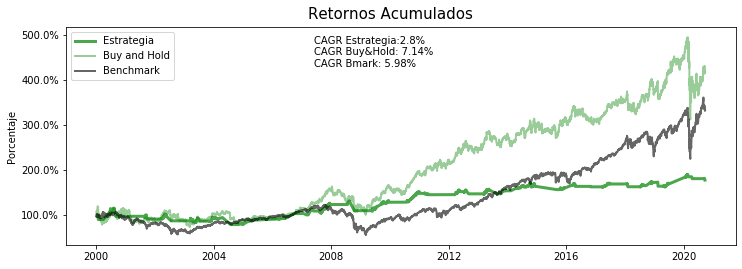

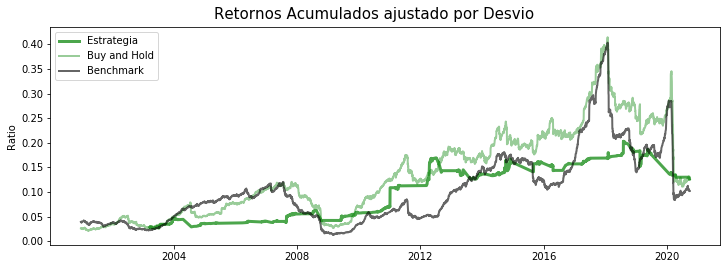

In [203]:
grafico_retornos_acumulados(estrategia_diario, df, bmark_signal, tipo = 'retornos')
grafico_retornos_acumulados(estrategia_diario, df, bmark_signal, tipo = 'retornos_desvio')

# 2) Sensibilidad de la Estrategia

In [322]:
%%time

#Defino los parameotrs Activo y Benchmark
symbol = 'KO'
benchmark = 'SPY'

#VARIABLES: defino el rango de las variables
lista_length = list(range(12,15))   #promedio de ruedas del indice
lista_adx_valor_entrada = list(range(23,27))  #valor del ADX al cual se ejecuta la operacion

#DF a construir para cada valor de las variables
retornos = []
retornos_desvio = []
retornos_desvioNeg = []
cagr_comparacion = []

#bajo la data
data = getData(symbol)
bmark_data = getData(benchmark)


for i in lista_length:
    length = i
    
    for j in lista_adx_valor_entrada:
        adx_valor_entrada = j

        #------FUNCIONES PREVIAMENTE DEFINIDAS------------------

        #corremos las funciones de la estrategia
        
        df = addSignal_DMI(data, adx_q = length, adx_accion = adx_valor_entrada)
        actions = getActions_DMI(df, long_short='both', adx_q = length)
        trades = getTrades(actions, long_short='both')
        tradesMetrics = getTradesMetrics(trades)

        #se recalcula la matriz de actions para que tome todos los dias sin filtro de ninguna señal
        #para luego calcular el valor diario de la cartera
        actions2 = getActions_DMI_comp(df, long_short='both', adx_q = length)

        #calculo el valor diario de la cartera segun mi estrategia
        estrategia_diario = estrategia_valor_diario(actions2, long_short='long')

        #armo los DF con el benchmark
        bmark_signal = addSignal_DMI(bmark_data, adx_q = length)

        #calculo las metricas anuales (retorno, desvio, desvio negativo, retorno ajustado por desvio/desvioneg)
        estrategia_anual = metrica_anual(estrategia_diario, estrategia = True)
        buy_hold_anual = metrica_anual(df, estrategia = False)
        bmark_anual = metrica_anual(bmark_signal)


        ##------FUNCIONES DEFINIDAS PARA EL ANALISIS DE SENSIBILIDAD------------------

        #calculo las medias de las metricas
        res_estrategia = estrategia_anual.mean()
        res_buyhold = buy_hold_anual.mean()
        res_bmark = bmark_anual.mean()

        #calculo el CAGR
        cagr_estrategia = cagr(estrategia_diario, estrategia = True)
        cagr_buyhold = cagr(df, estrategia = False)
        cagr_bmark = cagr(bmark_signal, estrategia = False)     

        #armo el DF resumen
        datos = pd.concat([res_estrategia,res_buyhold,res_bmark], axis = 1)
        datos.columns = ['Estrategia', 'Buy_Hold', 'Benchmark']
        datos.loc['CAGR','Estrategia'] = cagr_estrategia
        datos.loc['CAGR','Buy_Hold'] = cagr_buyhold
        datos.loc['CAGR','Benchmark'] = cagr_bmark

        #Agrego al DF Resumen la diferencia vs el Buy&Hold y el Benchmark
        datos['Estrat_BuyHold'] = datos.Estrategia - datos.Buy_Hold
        datos['Estrat_Benchmark'] = datos.Estrategia - datos.Benchmark
        datos['total_dif'] = datos.Estrat_BuyHold + datos.Estrat_Benchmark #armo columna para luego filtrar por esta misma


        #Armo los diccionarios con los datos por separado
            #Retornos
        ret_iteracion = {'Ruedas_DMI':length,
                     'ADX_valor_entrada': adx_valor_entrada,
                     'Estrat_media':datos.Estrategia['Variacion'],
                     'Estrat_BuyHold':datos.Estrat_BuyHold['Variacion'],
                     'Estrat_Benchmark': datos.Estrat_Benchmark['Variacion'],
                     'total_dif': datos.total_dif['Variacion']}

        retornos.append(ret_iteracion)


            #Retornos ajustados por desvio
        retDesv_iteracion = {'Ruedas_DMI':length,
                     'ADX_valor_entrada': adx_valor_entrada,
                     'Estrat_media':datos.Estrategia['RetAjustStd'],
                     'Estrat_BuyHold':datos.Estrat_BuyHold['RetAjustStd'],
                     'Estrat_Benchmark': datos.Estrat_Benchmark['RetAjustStd'],
                     'total_dif': datos.total_dif['RetAjustStd']}

        retornos_desvio.append(retDesv_iteracion)


            #Retornos ajustado por desvio negativo
        retDesvNeg_iteracion = {'Ruedas_DMI':length,
                     'ADX_valor_entrada': adx_valor_entrada,
                     'Estrat_media':datos.Estrategia['RetAjustStdDown'],
                     'Estrat_BuyHold':datos.Estrat_BuyHold['RetAjustStdDown'],
                     'Estrat_Benchmark': datos.Estrat_Benchmark['RetAjustStdDown'],
                     'total_dif': datos.total_dif['RetAjustStdDown']}

        retornos_desvioNeg.append(retDesvNeg_iteracion)

            #CAGR
        cagr_iteracion = {'Ruedas_DMI':length,
                     'ADX_valor_entrada': adx_valor_entrada,
                     'Estrat_media':datos.Estrategia['CAGR'],
                     'Estrat_BuyHold':datos.Estrat_BuyHold['CAGR'],
                     'Estrat_Benchmark': datos.Estrat_Benchmark['CAGR'],
                     'total_dif': datos.total_dif['CAGR']}

        cagr_comparacion.append(cagr_iteracion)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 51.5 s


In [317]:
def ordenar_resultados(df):
    resumen = pd.DataFrame(df).round(2)
    return resumen.sort_values('total_dif', ascending = False)

In [318]:
#Resultados de los Retornos (promedio anual)
ordenar_resultados(retornos)

,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
0,12,23,4.36,-3.84,-3.03,-6.87
4,13,23,4.32,-3.88,-3.07,-6.95
1,12,24,4.04,-4.16,-3.35,-7.51
8,14,23,4.02,-4.18,-3.37,-7.55
3,12,26,3.98,-4.22,-3.42,-7.64
2,12,25,3.76,-4.45,-3.64,-8.08
5,13,24,3.69,-4.51,-3.70,-8.20
7,13,26,3.55,-4.65,-3.84,-8.49
10,14,25,3.18,-5.02,-4.21,-9.23
6,13,25,3.15,-5.05,-4.25,-9.30


In [319]:
#Resultados de los Retornos Ajustado por Desvio (ratio)
ordenar_resultados(retornos_desvio)

,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
0,12,23,0.41,-0.21,-0.37,-0.58
1,12,24,0.40,-0.22,-0.37,-0.59
4,13,23,0.38,-0.25,-0.40,-0.64
8,14,23,0.34,-0.28,-0.43,-0.71
2,12,25,0.30,-0.32,-0.48,-0.80
5,13,24,0.29,-0.34,-0.49,-0.82
3,12,26,0.27,-0.35,-0.50,-0.86
10,14,25,0.26,-0.36,-0.51,-0.87
7,13,26,0.26,-0.37,-0.52,-0.88
6,13,25,0.24,-0.38,-0.53,-0.91


In [320]:
#Resultados de los Retornos Ajustado por Desvio Negativo (ratio)
ordenar_resultados(retornos_desvioNeg)

,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
8,14,23,0.71,-0.29,-0.36,-0.65
1,12,24,0.68,-0.32,-0.38,-0.70
7,13,26,0.68,-0.32,-0.39,-0.71
0,12,23,0.66,-0.34,-0.41,-0.75
3,12,26,0.66,-0.34,-0.41,-0.75
4,13,23,0.66,-0.34,-0.41,-0.75
2,12,25,0.61,-0.39,-0.46,-0.85
5,13,24,0.61,-0.39,-0.46,-0.85
10,14,25,0.61,-0.39,-0.46,-0.85
6,13,25,0.55,-0.45,-0.51,-0.96


In [321]:
#Resultados de CAGR (%)
ordenar_resultados(cagr_comparacion)

,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
0,12,23,4.03,-3.08,-1.91,-4.99
4,13,23,3.84,-3.27,-2.10,-5.37
1,12,24,3.60,-3.51,-2.34,-5.85
8,14,23,3.13,-3.98,-2.81,-6.79
10,14,25,2.80,-4.31,-3.14,-7.45
7,13,26,2.76,-4.35,-3.18,-7.53
2,12,25,2.52,-4.59,-3.42,-8.01
5,13,24,2.51,-4.60,-3.43,-8.03
3,12,26,2.31,-4.80,-3.63,-8.43
6,13,25,2.19,-4.92,-3.75,-8.67


# 3) Analisis de Portabilidad Básico

Traigo los tickers con mas volumen

In [334]:
import yfinance as yf
import pandas as pd

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500_tickers = list(sp500.Symbol)
sp500_tickers = [t for t in sp500_tickers if t not in ['BRK.B' ,'BF.B']]

def getDataM(listado, start='2000-01-01', interval='1d', end=None):
    data = yf.download(listado, start=start, end=end, interval=interval, auto_adjust=True)
    return data.swaplevel(i=1, j=0, axis=1)

In [335]:
df_sp500 = getDataM(sp500_tickers)

[*********************100%***********************]  503 of 503 completed


In [342]:
#Armo una funcion que me traiga los tickers con mas volumen de las ultimas 250 ruedas

def tickers_volumen(data, cantidad = 10):
    sp500 = data.copy()
    sp500bis = sp500.swaplevel(i=1, j=0, axis=1)
    volumen = sp500bis['Close'] * sp500bis['Volume'] / 1000000
    roll_vol = volumen.rolling(250).mean()[-1:].transpose()
    roll_vol.reset_index(inplace = True)
    roll_vol.columns = ['tickers', 'Vol_promedio_250dias']
    roll_vol_ordenado = roll_vol.sort_values('Vol_promedio_250dias', ascending = False)
    lista_tickers = roll_vol_ordenado.head(cantidad)['tickers']
    symbols = list(lista_tickers)
    return symbols

In [341]:
symbols = tickers_volumen(df_sp500, cantidad = 15)
symbols

['AAPL',
 'AMZN',
 'MSFT',
 'FB',
 'BA',
 'NVDA',
 'AMD',
 'NFLX',
 'GOOGL',
 'GOOG',
 'JPM',
 'V',
 'BAC',
 'DIS',
 'INTC']

### Analisis de Portabilidad

In [343]:
%%time

#Defino los parameotrs Activo y Benchmark
benchmark = 'SPY'
length = 14   #promedio de ruedas del indice
adx_valor_entrada = 25  #valor del ADX al cual se ejecuta la operacion

#VARIABLES: defino el rango de las variables
#son solo los simbolos


#DF a construir para cada valor de las variables
retornos = []
retornos_desvio = []
retornos_desvioNeg = []
cagr_comparacion = []

#bajo la data
bmark_data = getData(benchmark)


for i in symbols:
    symbol = i
    
    #------FUNCIONES PREVIAMENTE DEFINIDAS------------------

    #corremos las funciones de la estrategia
    data = getData(symbol)
    df = addSignal_DMI(data, adx_q = length, adx_accion = adx_valor_entrada)
    actions = getActions_DMI(df, long_short='both', adx_q = length)
    trades = getTrades(actions, long_short='both')
    tradesMetrics = getTradesMetrics(trades)

    #se recalcula la matriz de actions para que tome todos los dias sin filtro de ninguna señal
    actions2 = getActions_DMI_comp(df, long_short='both', adx_q = length)

    #calculo el valor diario de la cartera segun mi estrategia
    estrategia_diario = estrategia_valor_diario(actions2, long_short='long')

    #armo los DF con el benchmark
    bmark_signal = addSignal_DMI(bmark_data, adx_q = length)

    #calculo las metricas anuales (retorno, desvio, desvio negativo, retorno ajustado por desvio/desvioneg)
    estrategia_anual = metrica_anual(estrategia_diario, estrategia = True)
    buy_hold_anual = metrica_anual(df, estrategia = False)
    bmark_anual = metrica_anual(bmark_signal)


    ##------FUNCIONES DEFINIDAS PARA EL ANALISIS DE SENSIBILIDAD------------------

    #calculo las medias de las metricas
    res_estrategia = estrategia_anual.mean()
    res_buyhold = buy_hold_anual.mean()
    res_bmark = bmark_anual.mean()

    #calculo el CAGR
    cagr_estrategia = cagr(estrategia_diario, estrategia = True)
    cagr_buyhold = cagr(df, estrategia = False)
    cagr_bmark = cagr(bmark_signal, estrategia = False)     

    #armo el DF resumen
    datos = pd.concat([res_estrategia,res_buyhold,res_bmark], axis = 1)
    datos.columns = ['Estrategia', 'Buy_Hold', 'Benchmark']
    datos.loc['CAGR','Estrategia'] = cagr_estrategia
    datos.loc['CAGR','Buy_Hold'] = cagr_buyhold
    datos.loc['CAGR','Benchmark'] = cagr_bmark

    #Agrego al DF Resumen la diferencia vs el Buy&Hold y el Benchmark
    datos['Estrat_BuyHold'] = datos.Estrategia - datos.Buy_Hold
    datos['Estrat_Benchmark'] = datos.Estrategia - datos.Benchmark
    datos['total_dif'] = datos.Estrat_BuyHold + datos.Estrat_Benchmark


    #Armo los diccionarios con los datos por separado
        #Retornos
    ret_iteracion = {'Symbol': symbol,
                     'Ruedas_DMI':length,
                     'ADX_valor_entrada': adx_valor_entrada,
                     'Estrat_media':datos.Estrategia['Variacion'],
                     'Estrat_BuyHold':datos.Estrat_BuyHold['Variacion'],
                     'Estrat_Benchmark': datos.Estrat_Benchmark['Variacion'],
                     'total_dif': datos.total_dif['Variacion']}

    retornos.append(ret_iteracion)


        #Retornos ajustados por desvio
    retDesv_iteracion = {'Symbol': symbol,
                         'Ruedas_DMI':length,
                         'ADX_valor_entrada': adx_valor_entrada,
                         'Estrat_media':datos.Estrategia['RetAjustStd'],
                         'Estrat_BuyHold':datos.Estrat_BuyHold['RetAjustStd'],
                         'Estrat_Benchmark': datos.Estrat_Benchmark['RetAjustStd'],
                         'total_dif': datos.total_dif['RetAjustStd']}

    retornos_desvio.append(retDesv_iteracion)


        #Retornos ajustado por desvio negativo
    retDesvNeg_iteracion = {'Symbol': symbol,
                            'Ruedas_DMI':length,
                            'ADX_valor_entrada': adx_valor_entrada,
                            'Estrat_media':datos.Estrategia['RetAjustStdDown'],
                            'Estrat_BuyHold':datos.Estrat_BuyHold['RetAjustStdDown'],
                            'Estrat_Benchmark': datos.Estrat_Benchmark['RetAjustStdDown'],
                            'total_dif': datos.total_dif['RetAjustStdDown']}

    retornos_desvioNeg.append(retDesvNeg_iteracion)

        #CAGR
    cagr_iteracion = {'Symbol': symbol,
                      'Ruedas_DMI':length,
                      'ADX_valor_entrada': adx_valor_entrada,
                      'Estrat_media':datos.Estrategia['CAGR'],
                      'Estrat_BuyHold':datos.Estrat_BuyHold['CAGR'],
                      'Estrat_Benchmark': datos.Estrat_Benchmark['CAGR'],
                      'total_dif': datos.total_dif['CAGR']}

    cagr_comparacion.append(cagr_iteracion)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Dell\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Dell\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Wall time: 1min 12s


In [344]:
#Resultados de los Retornos (promedio anual)
ordenar_resultados(retornos)

,Symbol,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
12,BAC,14,25,27.03,16.45,19.69,36.13
0,AAPL,14,25,37.30,-5.71,29.96,24.25
10,JPM,14,25,8.37,-1.02,1.03,0.01
14,INTC,14,25,5.59,-2.68,-1.75,-4.44
2,MSFT,14,25,7.92,-5.79,0.58,-5.22
4,BA,14,25,6.85,-8.59,-0.49,-9.09
13,DIS,14,25,4.50,-6.57,-2.84,-9.41
3,FB,14,25,11.43,-18.30,4.09,-14.20
8,GOOGL,14,25,7.74,-21.41,0.40,-21.01
9,GOOG,14,25,7.68,-21.55,0.34,-21.21


In [347]:
#Resultados de los Retornos Ajustado por Desvio (ratio)
ordenar_resultados(retornos_desvio)

,Symbol,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
6,AMD,14,25,0.46,-0.11,-0.31,-0.42
0,AAPL,14,25,0.83,-0.58,0.06,-0.53
7,NFLX,14,25,0.73,-0.54,-0.04,-0.58
2,MSFT,14,25,0.40,-0.28,-0.38,-0.65
14,INTC,14,25,0.20,-0.24,-0.57,-0.81
4,BA,14,25,0.38,-0.44,-0.39,-0.84
1,AMZN,14,25,0.47,-0.58,-0.30,-0.88
3,FB,14,25,0.43,-0.64,-0.34,-0.99
5,NVDA,14,25,0.44,-0.68,-0.33,-1.01
9,GOOG,14,25,0.37,-0.70,-0.40,-1.10


In [348]:
#Resultados de los Retornos Ajustado por Desvio Negativo (ratio)
ordenar_resultados(retornos_desvioNeg)

,Symbol,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
0,AAPL,14,25,1.62,-0.67,0.56,-0.11
2,MSFT,14,25,0.91,-0.07,-0.16,-0.23
1,AMZN,14,25,1.41,-0.61,0.35,-0.26
6,AMD,14,25,0.80,-0.25,-0.27,-0.52
14,INTC,14,25,0.63,-0.09,-0.43,-0.53
4,BA,14,25,1.03,-0.51,-0.03,-0.55
7,NFLX,14,25,1.34,-1.17,0.28,-0.90
5,NVDA,14,25,1.05,-0.91,-0.02,-0.93
12,BAC,14,25,0.53,-0.43,-0.54,-0.96
10,JPM,14,25,0.48,-0.41,-0.59,-1.00


In [349]:
#Resultados de CAGR (%)
ordenar_resultados(cagr_comparacion)

,Symbol,Ruedas_DMI,ADX_valor_entrada,Estrat_media,Estrat_BuyHold,Estrat_Benchmark,total_dif
6,AMD,14,25,10.77,2.86,4.88,7.74
12,BAC,14,25,5.53,2.18,-0.36,1.82
4,BA,14,25,6.35,-2.57,0.46,-2.11
14,INTC,14,25,2.84,0.03,-3.05,-3.02
2,MSFT,14,25,4.98,-3.50,-0.91,-4.41
1,AMZN,14,25,7.87,-10.59,1.98,-8.61
10,JPM,14,25,1.65,-4.65,-4.24,-8.89
3,FB,14,25,11.08,-14.09,5.19,-8.90
0,AAPL,14,25,9.44,-16.75,3.55,-13.20
13,DIS,14,25,0.38,-8.04,-5.51,-13.55
